In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('lab15.ok')

Assignment: lab15
OK, version v1.13.11



# Lab 15: Clustering

In this lab you will explore K-Means and Agglomerative Clustering.

### Due Date

This assignment is due at **Wednesday, December 4th** at 11:59 pm.

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set()

## Vanilla Example

Let us begin with a toy dataset with three groups that are completely separated with the variables given. There are the same number of points per group and the same variance within each group.

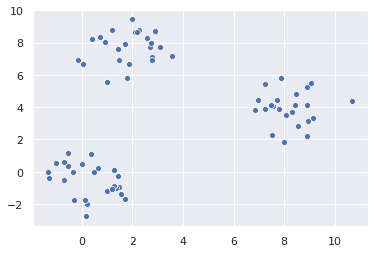

In [3]:
np.random.seed(1337)

c1 = np.random.randn(25, 2)
c2 = np.array([2, 8]) + np.random.randn(25, 2)
c3 = np.array([8, 4]) + np.random.randn(25, 2)

x1 = np.vstack((c1, c2, c3))

sns.scatterplot(x=x1[:, 0], y=x1[:, 1]);

Running the K-Means algorithm, we can see that it is able to accurately pick out the three initial clusters. 

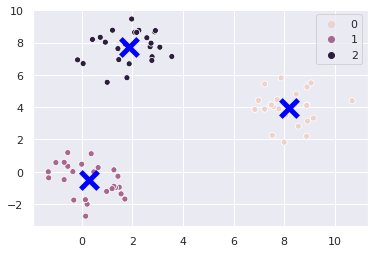

In [4]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42).fit(x1)
sns.scatterplot(x=x1[:, 0], y=x1[:, 1], hue=kmeans.labels_)
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='blue', marker='x', s=300, linewidth=5);

## Question 1

In the previous example, the K-Means algorithm was able to accurately find the three initial clusters. However, changing the starting centers for K-Means can change the final clusters that K-Means gives us. Change the initial centers to the points `[0, 1]`, `[1, 1]`, and `[2, 2]`; and fit a [`cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) object called `kmeans_q1` on the toy dataset from the previous example. Keep the `random_state` parameter as 42 and the `n_clusters` parameter as 3.

**Hint:** You will need to change the `init` and `n_init` parameters in `cluster.KMeans`.

<!--
BEGIN QUESTION
name: q1
-->

In [5]:
kmeans_q1 = cluster.KMeans(n_clusters=3, random_state=42, init=np.array([[0, 1], [1, 1], [2, 2]]), n_init=3).fit(x1)

/srv/conda/envs/data100/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=3
  return_n_iter=True)


In [6]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Running the K-Means algorithm with these centers gives us a different result from before, and this particular run of K-Means was unable to accurately find the three initial clusters.

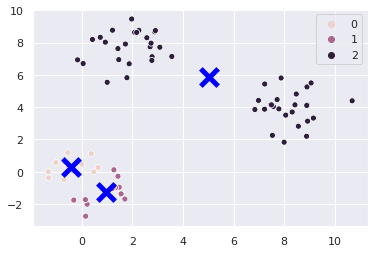

In [7]:
sns.scatterplot(x=x1[:, 0], y=x1[:, 1], hue=kmeans_q1.labels_)
sns.scatterplot(kmeans_q1.cluster_centers_[:, 0], kmeans_q1.cluster_centers_[:, 1], color='blue', marker='x', s=300, linewidth=5);

## Question 2

Sometimes, K-Means will have a difficult time finding the "correct" clusters even with ideal starting centers. For example, consider the data below. There are two groups of different sizes in two different senses. The smaller group has both smaller variability and is less numerous, and the larger of the two groups is more diffuse and populated.

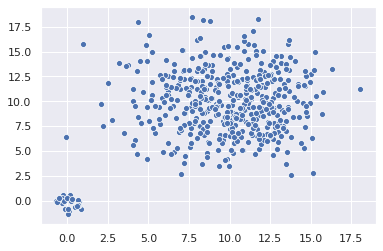

In [8]:
np.random.seed(1337)

c1 = 0.5 * np.random.randn(25, 2)
c2 = np.array([10, 10]) + 3*np.random.randn(475, 2)

x2 = np.vstack((c1, c2))

sns.scatterplot(x=x2[:, 0], y=x2[:, 1]);

### Question 2a

Fit a `cluster.KMeans` object called `kmeans_q2a` on the dataset above with two clusters and a `random_state` parameter of 42.

<!--
BEGIN QUESTION
name: q2a
-->

In [9]:
kmeans_q2a = cluster.KMeans(random_state=42, n_clusters=2).fit(x2)

In [10]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



(For notational simplicity we will call the initial cluster on the bottom left $A$ and the initial cluster on the top right $B$. We will call the bottom left cluster found by K-Means as cluster $a$ and the top right cluster found by K-Means as cluster $b$.) 

As seen below, K-Means is unable to find the two intial clusters because cluster $a$ includes points from cluster $B$. Recall that K-Means attempts to minimize distortion, so it makes sense that points in the bottom left of cluster $B$ would prefer to be in cluster $a$ rather than cluster $b$. If these points were in cluster $b$ instead, then the resulting cluster assignments would have a larger distortion.

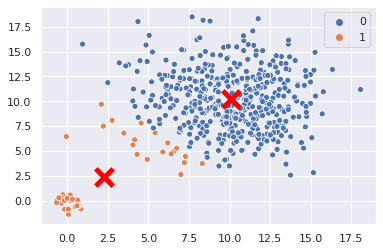

In [11]:
sns.scatterplot(x=x2[:, 0], y=x2[:, 1], hue=kmeans_q2a.labels_)
sns.scatterplot(kmeans_q2a.cluster_centers_[:, 0], kmeans_q2a.cluster_centers_[:, 1], color='red', marker='x', s=300, linewidth=5);

### Question 2b

It turns out agglomerative clustering works better for this task, as long as we choose the right definition of distance between two clusters. Recall that agglomerative clustering starts with every data point in its own cluster and iteratively joins the two closest clusters until there are $K$ clusters remaining. However, the "distance" between two clusters is ambiguous. 

In lecture 26 we used the maximum distance between a point in the first cluster and a point in the second as this notion of distance, but there are other ways to define the distance between two clusters. 

Our choice of definition for the distance is sometimes called the "linkage criterion." We will discuss three linkage criteria, each of which is a different definition of "distance" between two clusters:

- Complete linkage considers the distance between two clusters as the **maximum** distance between a point in the first cluster and a point in the second. This is what we did in [lecture 26](https://docs.google.com/presentation/d/1i5tIhNx50Xu-hxffMubQ_aOCu2tRQNHLrzUyu8GQAkI/edit#slide=id.g756fb96d6d_0_31).
- Single linkage considers the distance between two clusters as the **minimum** distance between a point in the first cluster and a point in the second.
- Average linkage considers the distance between two clusters as the **average** distance between a point in the first cluster and a point in the second.

Using the **complete linkage criterion**, fit a [`cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) object called `aggc_q2b` on the dataset above with two clusters.

<!--
BEGIN QUESTION
name: q2b
-->

In [12]:
aggc_q2b = cluster.AgglomerativeClustering(linkage='complete').fit(x2)

In [13]:
ok.grade("q2b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Below we visualize the results of your model. Note that complete linkage agglomerative clustering has the same issue as K-Means in that the bottom left cluster found by complete linkage agglomerative clustering includes points from the top right cluster. However, we can remedy this by picking a different linkage criterion.

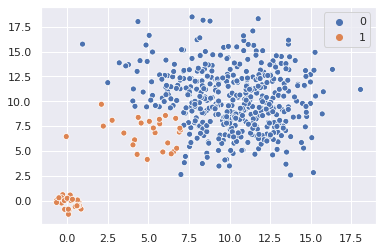

In [14]:
sns.scatterplot(x=x2[:, 0], y=x2[:, 1], hue=aggc_q2b.labels_);

### Question 2c

Now, use the average linkage criterion to fit a `cluster.AgglomerativeClustering` object called `aggc_q2c` on the dataset above with two clusters.

**Note:** We intended for you to use single linkage, but the version of sklearn installed on DataHub (0.19) does not support single linkage agglomerative clustering.

<!--
BEGIN QUESTION
name: q2c
-->

In [15]:
aggc_q2c = cluster.AgglomerativeClustering(linkage='average').fit(x2)

In [16]:
ok.grade("q2c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Finally, we see that average linkage agglomerative clustering is able to find the two initial clusters.

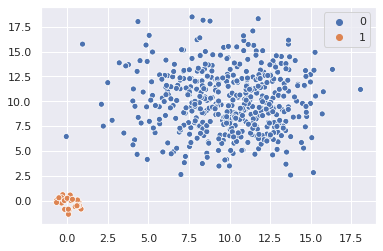

In [17]:
sns.scatterplot(x=x2[:, 0], y=x2[:, 1], hue=aggc_q2c.labels_);

You might be curious why average linkage "works" while complete linkage does not in this scenario; we will leave this as an exercise for students who are interested.

## Question 3

For this question, consider the following toy dataset.

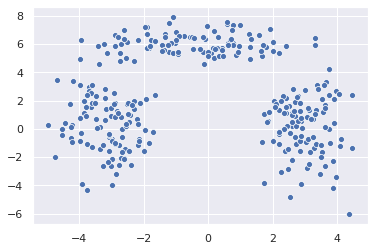

In [18]:
np.random.seed(1337)

c1 = np.random.multivariate_normal([-3,0], [[.5,0],[0,4]], 100)
c2 = np.random.multivariate_normal([3,0], [[.5,0],[0,4]], 100)
c3 = np.random.multivariate_normal([0,6], [[4,0],[0,.5]], 100)
x3 = np.vstack((c1, c2, c3))

sns.scatterplot(x=x3[:, 0], y=x3[:, 1]);

### Question 3a

Fit three different `cluster.KMeans` objects on the dataset above called `kmeans_q32`, `kmeans_q33`, and `kmeans_q34`. These three objects should be fit with two, three, and four clusters respectively. Use a `random_state` parameter of 42.

<!--
BEGIN QUESTION
name: q3a
-->

In [19]:
kmeans_q32 = cluster.KMeans(n_clusters=2, random_state=42).fit(x3)
kmeans_q33 = cluster.KMeans(n_clusters=3, random_state=42).fit(x3)
kmeans_q34 = cluster.KMeans(n_clusters=4, random_state=42).fit(x3)

In [20]:
ok.grade("q3a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



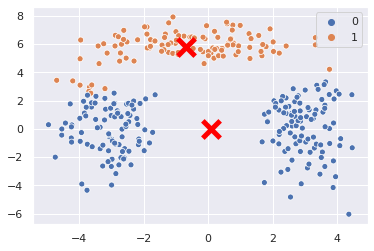

In [21]:
sns.scatterplot(x=x3[:, 0], y=x3[:, 1], hue=kmeans_q32.labels_)
sns.scatterplot(kmeans_q32.cluster_centers_[:, 0], kmeans_q32.cluster_centers_[:, 1], color='red', marker='x', s=300, linewidth=5);

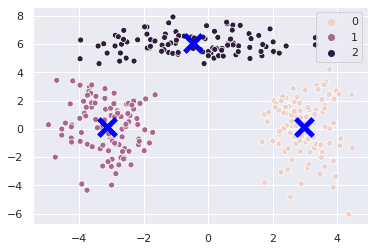

In [22]:
sns.scatterplot(x=x3[:, 0], y=x3[:, 1], hue=kmeans_q33.labels_)
sns.scatterplot(kmeans_q33.cluster_centers_[:, 0], kmeans_q33.cluster_centers_[:, 1], color='blue', marker='x', s=300, linewidth=5);

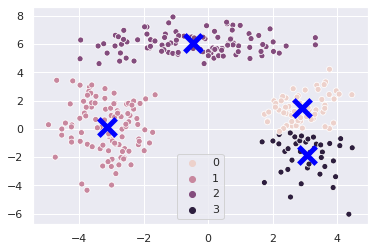

In [23]:
sns.scatterplot(x=x3[:, 0], y=x3[:, 1], hue=kmeans_q34.labels_)
sns.scatterplot(kmeans_q34.cluster_centers_[:, 0], kmeans_q34.cluster_centers_[:, 1], color='blue', marker='x', s=300, linewidth=5);

### Question 3b

Based on the three plots above, how many clusters do you think we should use? Assign your answer to the variable `k_q3b`.

**Note:** We will accept any of the three possible answers here, but one of the three plots might be more visually appealing than the other two.

<!--
BEGIN QUESTION
name: q3b
-->

In [24]:
k_q3b = 3

In [25]:
ok.grade("q3b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 3c

We can also use silhouette plots to select the number of clusters $K$. The following code is borrowed from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html.

For n_clusters = 2 The average silhouette_score is : 0.43777634382218217
For n_clusters = 3 The average silhouette_score is : 0.6124109876911771
For n_clusters = 4 The average silhouette_score is : 0.5671387911067025


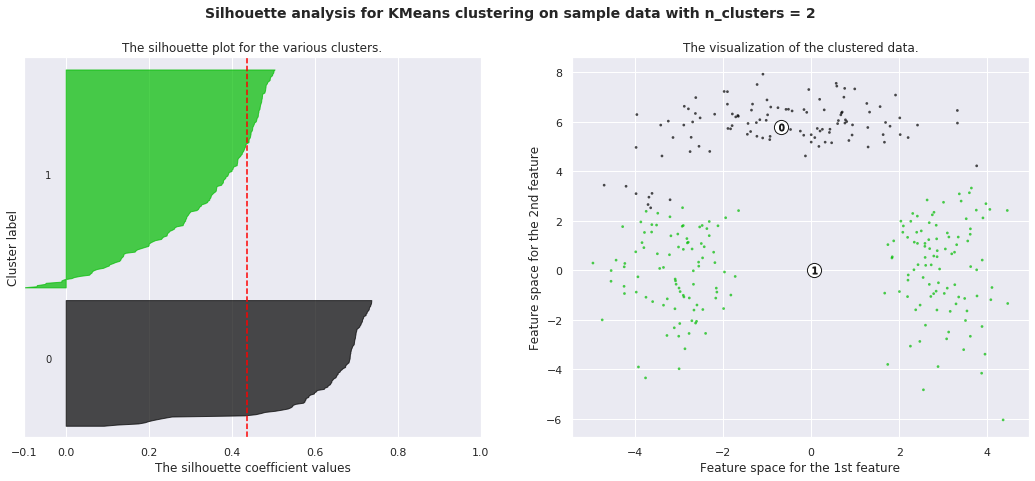

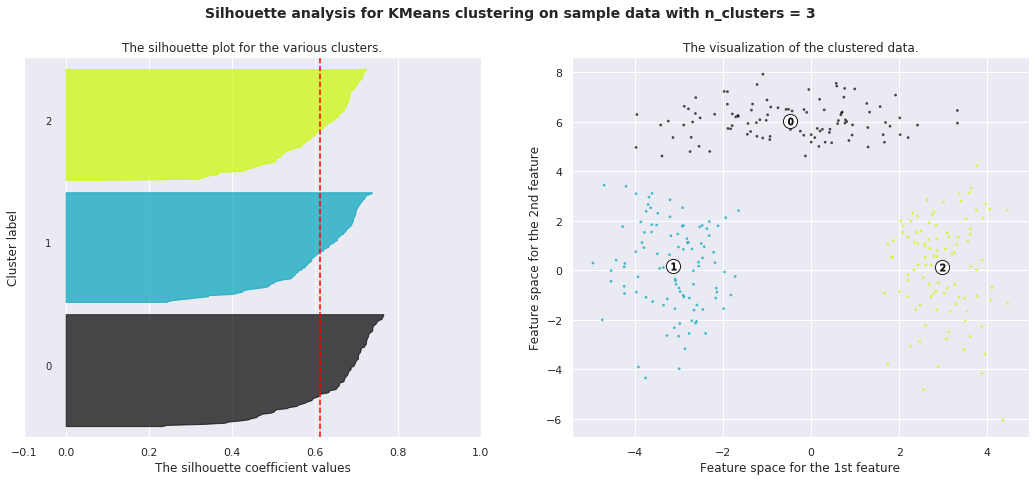

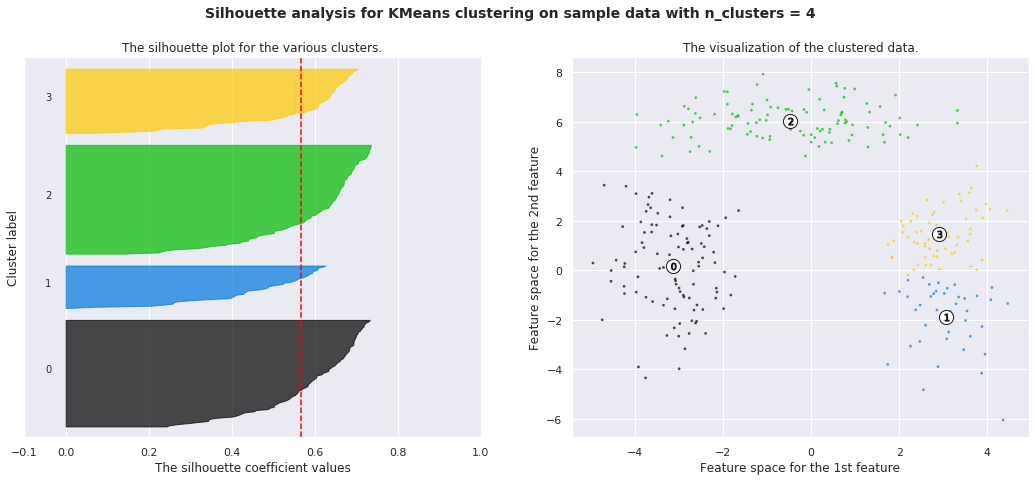

In [26]:
X = x3

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Suppose we want to pick the number of clusters based on the highest average silhouette score. Given the silhouette plots above, how many clusters should we use? Assign your answer to the variable `k_q3c`.

<!--
BEGIN QUESTION
name: q3c
-->

In [27]:
k_q3c = 3

In [28]:
ok.grade("q3c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Question 4

In the previous three questions, we looked at clustering on two dimensional datasets. However, we can easily use clustering on data which have more than two dimensions. For this, let us turn to a World Bank dataset, containing various features for the world's countries.

This data comes from https://databank.worldbank.org/source/world-development-indicators#.


In [29]:
world_bank_data = pd.read_csv("world_bank_data.csv", index_col = 'country')
world_bank_data.head(5)

Age dependency ratio (% of working-age population)  \
country                                                              
Algeria                                                 57.508032    
Afghanistan                                             84.077656    
Albania                                                 45.810037    
American Samoa                                                NaN    
Andorra                                                       NaN    

                Age dependency ratio, old (% of working-age population)  \
country                                                                   
Algeria                                                 10.021442         
Afghanistan                                              4.758273         
Albania                                                 20.041214         
American Samoa                                                NaN         
Andorra                                                       NaN         

                Age dependency ratio, young (% of working-age population)  \
country                                                                     
Algeria                                                 47.486590           
Afghanistan                                             79.319383           
Albania                                                 25.768823           
American Samoa                                                NaN           
Andorra                                                       NaN           

                Bird species, threatened  \
country                                    
Algeria                             15.0   
Afghanistan                         16.0   
Albania                              8.0   
American Samoa                       8.0   
Andorra                              3.0   

                Business extent of disclosure index (0=less disclosure to 10=more disclosure)  \
country                                                                                         
Algeria                                                       4.0                               
Afghanistan                                                   8.0                               
Albania                                                       9.0                               
American Samoa                                                NaN                               
Andorra                                                       NaN                               

                Contributing family workers, female (% of female employment) (modeled ILO estimate)  \
country                                                                                               
Algeria                                                  2.720000                                     
Afghanistan                                             71.780998                                     
Albania                                                 37.987000                                     
American Samoa                                                NaN                                     
Andorra                                                       NaN                                     

                Contributing family workers, male (% of male employment) (modeled ILO estimate)  \
country                                                                                           
Algeria                                                     1.836                                 
Afghanistan                                                 9.606                                 
Albania                                                    20.795                                 
American Samoa                                                NaN                                 
Andorra                                                       NaN                                 

                Contributing family workers, total (% 

There are some missing values. For the sake of convenience and of keeping the lab short, we will fill them all with zeros. 

In [30]:
world_bank_data = world_bank_data.fillna(0)

Using all available features, fit a `cluster.KMeans` object called `kmeans_q4` with four clusters and a `random_state` parameter of 42.

<!--
BEGIN QUESTION
name: q4
-->

In [31]:
kmeans_q4 = cluster.KMeans(n_clusters=4, random_state=42).fit(world_bank_data)

In [32]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Looking at the clusters, we see that almost all countries get clustered together, and the other 3 clusters seem to have countries with vaguely similar levels of economic and geopolitcal power.

In [33]:
labeled_world_bank_data = world_bank_data.copy()
labeled_world_bank_data['cluster'] = kmeans_q4.labels_

In [34]:
list(labeled_world_bank_data.query('cluster == 0').index)

['Algeria',
 'Afghanistan',
 'Albania',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Channel Islands',
 'Chile',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'French Polynesia',
 'Gabon',
 'Gambia, The',
 'Georgia

In [35]:
list(labeled_world_bank_data.query('cluster == 1').index)

['China', 'United States']

In [36]:
list(labeled_world_bank_data.query('cluster == 2').index)

['Germany', 'India', 'Japan']

In [37]:
list(labeled_world_bank_data.query('cluster == 3').index)

['Australia',
 'Brazil',
 'Canada',
 'France',
 'Indonesia',
 'Italy',
 'Korea, Rep.',
 'Mexico',
 'Russian Federation',
 'Saudi Arabia',
 'Spain',
 'Turkey',
 'United Kingdom']

To understand the meaning of these clusters, we could look at `kmeans_q4.cluster_centers_`. We leave this as a very challenging exercise for students who are especially interested.

## Question 5

Like with PCA, it sometimes makes sense to center and scale our data so that features with higher variance don't dominate the analysis. For example, in the clustering above, statistics like population will completely dominate features like % of total population that live in urban areas. This is because population can range over billions whereas % is always between 0 and 100. The ultimate effect is that we're not really using most of our columns at all.

Below, repeat the clustering process from question 4. As before, fit a `cluster.KMeans` object called `kmeans_q5` with four clusters and a `random_state` parameter of 42.

The difference is that this time you should use a centered and scaled version of the world bank data. By centered and scaled we mean that the mean in each column should be zero and the variance should be 1.

<!--
BEGIN QUESTION
name: q5
-->

In [38]:
world_bank_data = (world_bank_data - world_bank_data.mean()) / world_bank_data.std()

kmeans_q5 = cluster.KMeans(random_state=42, n_clusters=4).fit(world_bank_data)

In [39]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Looking at these new clusters, we see that they seem to correspond to:

0: Very small countries.

1: Developed countries.

2: Less developed countries.

3: Huge countries.

In [40]:
labeled_world_bank_data_q5 = pd.Series(kmeans_q5.labels_, name = "cluster", index  = world_bank_data.index).to_frame()
labeled_world_bank_data_q5

cluster
country                       
Algeria                      2
Afghanistan                  2
Albania                      1
American Samoa               0
Andorra                      0
...                        ...
Virgin Islands (U.S.)        1
West Bank and Gaza           2
Yemen, Rep.                  2
Zambia                       2
Zimbabwe                     2

[217 rows x 1 columns]

In [41]:
list(labeled_world_bank_data_q5.query('cluster == 0').index)

['American Samoa',
 'Andorra',
 'Aruba',
 'Bermuda',
 'British Virgin Islands',
 'Cayman Islands',
 'Curacao',
 'Dominica',
 'Faroe Islands',
 'Gibraltar',
 'Greenland',
 'Isle of Man',
 'Kosovo',
 'Liechtenstein',
 'Marshall Islands',
 'Monaco',
 'Nauru',
 'Northern Mariana Islands',
 'Palau',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'St. Kitts and Nevis',
 'St. Martin (French part)',
 'Turks and Caicos Islands',
 'Tuvalu']

In [42]:
list(labeled_world_bank_data_q5.query('cluster == 1').index)

['Albania',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Barbados',
 'Belarus',
 'Belgium',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Canada',
 'Channel Islands',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'El Salvador',
 'Estonia',
 'Finland',
 'France',
 'French Polynesia',
 'Georgia',
 'Germany',
 'Greece',
 'Grenada',
 'Guam',
 'Hong Kong SAR, China',
 'Hungary',
 'Iceland',
 'Iran, Islamic Rep.',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Korea, Rep.',
 'Kuwait',
 'Latvia',
 'Lebanon',
 'Libya',
 'Lithuania',
 'Luxembourg',
 'Macao SAR, China',
 'Malaysia',
 'Maldives',
 'Malta',
 'Mauritius',
 'Mexico',
 'Moldova',
 'Montenegro',
 'Netherlands',
 'New Caledonia',
 'New Zealand',
 'North Macedonia',
 'Norway',
 'Oman',
 'Panama',
 'Poland',
 'Portugal',

In [43]:
list(labeled_world_bank_data_q5.query('cluster == 2').index)

['Algeria',
 'Afghanistan',
 'Angola',
 'Bangladesh',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Botswana',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Djibouti',
 'Ecuador',
 'Egypt, Arab Rep.',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Gabon',
 'Gambia, The',
 'Ghana',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Indonesia',
 'Iraq',
 'Kenya',
 'Kiribati',
 'Korea, Dem. People’s Rep.',
 'Kyrgyz Republic',
 'Lao PDR',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Micronesia, Fed. Sts.',
 'Mongolia',
 'Morocco',
 'Mozambique',
 'Myanmar',
 'Namibia',
 'Nepal',
 'Nicaragua',
 'Niger',
 'Nigeria',
 'Pakistan',
 'Papua New Guinea',
 'Paraguay',
 'Peru',
 'Philippines',
 'Rwanda',
 'Samoa',
 'Sao Tome and Principe',
 'Senegal',
 'Sierra Leone',
 'Solomon Islands',


In [44]:
list(labeled_world_bank_data_q5.query('cluster == 3').index)

['China', 'India', 'United States']

# Make sure to complete Vitamin 15 on Gradescope by 11:59 PM on Wednesday, 12/4!

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

In [ ]:
# Save your notebook first, then run this cell to submit.
ok.submit()

<IPython.core.display.Javascript object>